In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
#file = open("sim_data_no_noise_50frames.pkl", "rb")

#sim_data = pickle.load(file)

#file.close()


In [3]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [4]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]


## Setting up the target

In [5]:
target_model_1 = mmars.Target(start_position=np.array([[5.001,5.001]]), start_velocity=5., T_total=10., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

In [6]:
simulation_data = mmars.Simulation(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x0000025CA0DC6520> and <mmars.target.Target object at 0x0000025CA0DC61F0>


100%|██████████| 100/100 [00:00<00:00, 1122.29it/s]


In [7]:
sim_data = simulation_data.get_data()
lambda_z_coefficient = radar_model_1.get_standardDeviation()
lambda_z_coefficient

np.float64(2.763854534117991e-07)

In [8]:
wavelength = c/77e9

def generate_S_signal(
                    target_x, 
                    target_y, 
                    position=np.array([[0,0]]),
                    tx_antennas = np.array(([-12*(wavelength/2), 0],
                                           [-8*(wavelength/2), 0],
                                           [-4*(wavelength/2), 0])),
                    rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                    [-(1/2)*(wavelength/2), 0],
                                    [(1/2)*(wavelength/2), 0],
                                    [(3/2)*(wavelength/2), 0])),
                    chirp_Rate = 30e6/1e-6, 
                    T_chirp = 25.66e-6,
                    transmitPower = 1,
                    gain = 1,
                    radarCrossSection = 1,
                    f_sampling = 20e6,
                    N_samples = 256,
                    N_chirps = 1,
                    wavelength = c/77e9
                    ):
        
    S_signal = np.zeros((tx_antennas.shape[0], rx_antennas.shape[0], N_chirps, N_samples),dtype=complex)
    target_position = np.array([target_x, target_y])

    # Compute the radial distance to the target
    radial_distance = np.linalg.norm(position - target_position, axis=1)


    # Compute all distances between TX and RX antennas and the target
    distances = np.zeros((len(tx_antennas), len(rx_antennas)))
    for tx_idx in range(len(tx_antennas)):
        for rx_idx in range(len(rx_antennas)):
            distances[tx_idx,rx_idx] = np.linalg.norm(tx_antennas[tx_idx] - target_position) + np.linalg.norm(rx_antennas[rx_idx] - target_position)

    # Compute the phase difference between the antennas
    phase_diff_TX_RX = 2*np.pi*distances/wavelength
    phase_diff_TX_RX -= phase_diff_TX_RX[0,0]

    # Compute the Intermediate frequency (IF) frequency:
    f_IF = (2*radial_distance*chirp_Rate)/c 

    # Compute the received power:
    received_power = transmitPower*gain*wavelength**2*radarCrossSection/( (4*np.pi)**3 * radial_distance**4)
    
    # Generate the IF signal
    freqs = np.linspace(0,2 * np.pi, N_samples)[np.newaxis]  # Time variable running from 0 to N_samples/F_sampling
    #time = np.linspace(0, N_samples/f_sampling, N_samples)[np.newaxis]
    for tx_idx in range(tx_antennas.shape[0]):
        for rx_idx in range(rx_antennas.shape[0]): 
            #index = np.argmin(np.abs((np.ones((N_chirps,1))@freqs) - f_IF))
            #S_signal[tx_idx, rx_idx, :, :] = np.sinc(((np.ones((N_chirps,1))@freqs) - f_IF) *1/2 * T_chirp *1/np.pi) *np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx])# Changes with antennas
            #S_signal[tx_idx, rx_idx, :, :] = (np.exp(1j*2*np.pi*f_IF*(np.ones((N_chirps,1))@time)) # Changes with ADC samples
             #                                            *np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx]) # Changes with antennas
              #                                          )
            S_signal[tx_idx, rx_idx, :, :] =  (np.exp(-1.j * freqs * N_samples/2) * np.sin((freqs - f_IF /f_sampling * 2 * np.pi) * (N_samples + 1) * 1/2) / np.sin((freqs - f_IF/f_sampling * 2 * np.pi)/2)
                                              )*np.exp(1j*phase_diff_TX_RX[tx_idx,rx_idx])
            
    S_signal *= np.sqrt(received_power) # Scale the signal based on the received power

    return S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

In [154]:
frame = 1

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier

S_N = generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

5.500791692706784 5.501


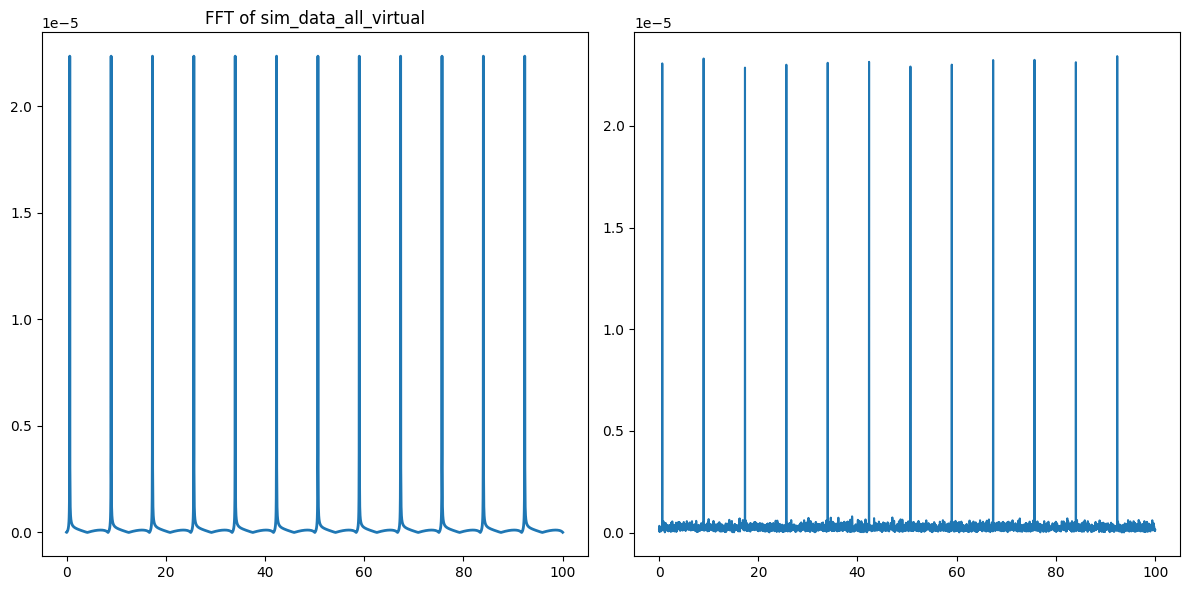

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(S_N), lw=2)
axs[1].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T))

#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')


#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

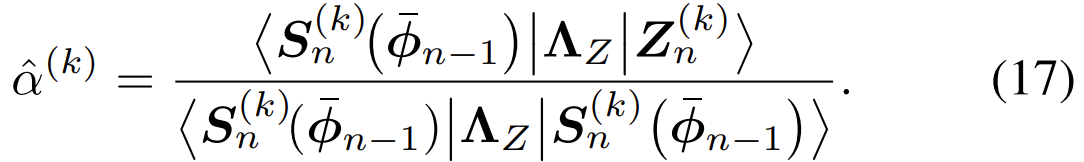

In [11]:
Lambda_z = np.eye(3072) * (lambda_z_coefficient)
lambda_z = csr_matrix(Lambda_z)

def alpha_hat(phi_mu_x, phi_mu_y, data_fourier):
    s_nn = generate_S_signal(phi_mu_x, phi_mu_y)
    
    # Compute conjugate transpose once
    s_nn_H = s_nn.conj().T  # Conjugate transpose
    
    return (s_nn_H @ lambda_z @ data_fourier) / (s_nn_H @ lambda_z @ s_nn)

In [12]:
np.abs(alpha_hat(target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[1][frame-1], data_fourier.T))

array([[0.09795343]])

In [13]:
def jacobian_S(epsilon,
                        position = np.array([0, 0]),
                        tx_antennas = None, rx_antennas = None,
                        S=30e6/1e-6,T_chirp=25.66e-6, transmitPower=1, gain=1, radarCrossSection=1,
                        f_sampling=20e6, N_samples=256, N_chirps=1, c = 299792458, start_freq = 77e9):
    
    wavelength = c/start_freq
    if tx_antennas is None:
        tx_antennas = np.array(([-12*(wavelength/2), 0],
                                [-8*(wavelength/2), 0],
                                [-4*(wavelength/2), 0]))
    if rx_antennas is None:
        rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                [-(1/2)*(wavelength/2), 0],
                                [(1/2)*(wavelength/2), 0],
                                [(3/2)*(wavelength/2), 0]))
        
    N_vx_antennas = len(tx_antennas) * len(rx_antennas)
    x, y = epsilon
    x_r, y_r = position

    ## related to path loss
    A = np.sqrt(transmitPower * gain * radarCrossSection * wavelength**2 / (4 * np.pi)**3)

    ## related to steering matrix
    ds = np.arange(0, N_vx_antennas * wavelength/2, wavelength/2)

    ## related to sinc fnc
    freqs = np.linspace(0, 2 * np.pi, N_samples)[np.newaxis]

    def path_loss(x, y):
        """path loss"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        alpha = A/r**2
        return alpha

    def partial_path_loss(x, y, x__R, y__R):
        """path loss alpha partial differentiated w.r.t first entry (works for x/y)"""
        r = np.sqrt((x - x__R)**2 + (y - y__R)**2)
        partial_alpha = - 2 * A * r**(-4) * (x - x__R)
        return partial_alpha

    def steering_matrix(x, y):
        """steering matrix"""
        deltaR = np.sin(-np.atan2(x - x_r, y - y_r)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        steering_mat = np.exp(1.j * 2 * np.pi * phi)
        return steering_mat[:, np.newaxis]

    def partial_steering_matrix(x, y, x__R, y__R, x_partial=True):
        """steering matrix partial differentiated w.r.t x/y"""
        exp1 = 1 + (x - x__R)**2/(y - y__R)**2
        partial_deltaR = (-(1/((y - y__R) * np.sqrt(exp1))) + (x - x__R)**2/((y - y__R)**3 * exp1**(3/2))) * ds
        
        if not x_partial:
            partial_deltaR = ((x - x__R)/((y - y__R)**2 * np.sqrt(exp1)) - ((x - x__R)**3/((y - y__R)**4 * exp1**(3/2)))) * ds

        partial_phi_deltaR = 2 * np.pi/wavelength

        deltaR = np.sin(-np.atan2(x, y)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        partial_a_phi = 1.j * 2 * np.pi * np.exp(1.j * 2 * np.pi * phi)
        partial_steering_mat = partial_a_phi * partial_phi_deltaR * partial_deltaR
        return partial_steering_mat[:, np.newaxis]
        
    def sinc(x, y):
        """sinc function"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        f_IF = 2 * S * r / c * (2 * np.pi / f_sampling)
        K = np.exp(-1.j * freqs * N_samples/2)

        sinc_fnc = K * np.sin((freqs - f_IF) * (N_samples + 1) * 1/2)/np.sin((freqs - f_IF)/2)
        return sinc_fnc
    
    def partial_sinc(x, y, x__R, y__R):
        """sinc fnc (fourier transform of window fnc) partially differentiated w.r.t. first entry"""
        K = np.exp(-1.j * freqs * N_samples/2)
        f = freqs
        N__s = N_samples

        # from Maple:
        partial_sinc = (K * S * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * np.pi * (2 * x - 2 * x__R) * (N__s + 1) 
                        * np.cos((f - S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 5000000) * (N__s + 1) / 2) 
                        / np.sin(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) / 20000000 + K 
                        * np.sin((f - S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 5000000) * (N__s + 1) / 2) 
                        / np.sin(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) ** 2 * S 
                        * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * np.pi * (2 * x - 2 * x__R) 
                        * np.cos(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) / 20000000
                        )
        return partial_sinc

    S_tilde = steering_matrix(x, y) @ sinc(x, y)
    partial_S_tilde_x = partial_steering_matrix(x, y, x_r, y_r, x_partial=True) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(x, y, x_r, y_r)
    S_jacobian_x = np.reshape(partial_S_tilde_x * path_loss(x, y) + S_tilde * partial_path_loss(x, y, x_r, y_r), [N_vx_antennas * N_samples])[:, np.newaxis]

    partial_S_tilde_y = partial_steering_matrix(x, y, x_r, y_r, x_partial=False) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(y, x, y_r, x_r)
    S_jacobian_y = np.reshape(partial_S_tilde_y * path_loss(x, y) + S_tilde * partial_path_loss(y, x, y_r, x_r), [N_vx_antennas * N_samples])[:, np.newaxis]

    S_jacobian = np.hstack((S_jacobian_x, S_jacobian_y))
    return S_jacobian

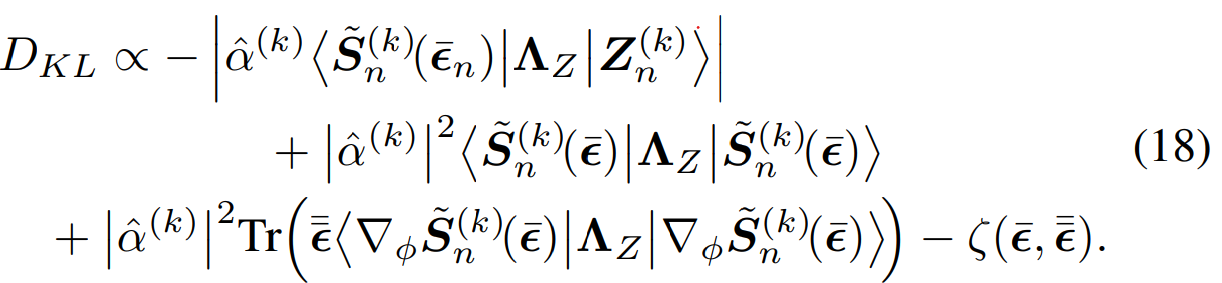

In [402]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (lambda_z_coefficient)**(-1)
Lambda_z = csr_matrix(Lambda_z)

def D_KL(params, Z_data, phi_bar_last_x, phi_bar_last_y):
    eps_bar_x, eps_bar_y, eps_barbar_0, eps_barbar_1 = params

    alpha_hat_xy = alpha_hat(phi_bar_last_x, phi_bar_last_y, Z_data)
    
    s_n = generate_S_signal(eps_bar_x, eps_bar_y)

    term_1 = -np.abs(alpha_hat_xy * (s_n.conj().T @ Lambda_z @ Z_data))
    term_2 = np.real(np.abs(alpha_hat_xy)**2 * s_n.conj().T @ Lambda_z @ s_n)
    
    jac = jacobian_S(np.array([eps_bar_x, eps_bar_y]))
    term_3_inner_prod = np.real(jac.conj().T @ Lambda_z @ jac)
    
    term_3 = np.abs(alpha_hat_xy)**2 * np.trace(np.array([[eps_barbar_0, 0], [0, eps_barbar_1]]) * term_3_inner_prod)
    k = 2
    entropy = k/2 * np.log(2*np.pi*np.e) + 1/2*np.log(eps_barbar_0 * eps_barbar_1)
    
    print(term_1, term_2, term_3, entropy)

    return term_1 + term_2 + term_3 - entropy

In [403]:
frame = 10

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [404]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]
print(last_frame_x, last_frame_y)

result = minimize(D_KL, (last_frame_x, last_frame_y, 0.5, 0.5), bounds = [(1,50), (1,50), (0, 10), (0, 10)],  args=(data_fourier, target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[0][frame]), method='nelder-mead')

9.350655341112304 9.501000000000001
[[-9.67019686e-06]] [[0.0004519]] [[3.90094953]] 2.1447298858494
[[-0.00012206]] [[0.0004074]] [[3.30889888]] 2.1447298858494
[[-0.00010996]] [[0.00040688]] [[3.5164106]] 2.1447298858494
[[-9.67019686e-06]] [[0.0004519]] [[3.99908423]] 2.169124967934116
[[-9.67019686e-06]] [[0.0004519]] [[3.9978623]] 2.169124967934116
[[-0.00012477]] [[0.00040735]] [[3.3754667]] 2.1314295449508105
[[-0.00030755]] [[0.00038253]] [[3.12101978]] 2.112960375447156
[[-0.00088616]] [[0.00036255]] [[2.73588146]] 2.083248665211756
[[-0.00079698]] [[0.00034516]] [[2.6900533]] 2.1080978971214352
[[-0.0001851]] [[0.00030254]] [[2.25756288]] 2.0892395544391045
[[-0.00036198]] [[0.00032721]] [[2.3649227]] 2.079668174412523
[[-0.00017237]] [[0.00029559]] [[2.08101137]] 2.065386659131308
[[-2.07861249e-05]] [[0.00026369]] [[1.62054012]] 2.0281217966748164
[[-6.98379657e-05]] [[0.00024016]] [[1.49998268]] 1.9911812537845603
[[-6.50674226e-06]] [[0.00019592]] [[1.01040446]] 1.9037148

In [401]:
print(f"{result}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 118.08024222472758
             x: [ 9.894e+00  2.371e+01  7.918e-07  7.329e-07]
           nit: 183
          nfev: 340
 final_simplex: (array([[ 9.894e+00,  2.371e+01,  7.918e-07,  7.329e-07],
                       [ 9.894e+00,  2.371e+01,  7.948e-07,  7.480e-07],
                       ...,
                       [ 9.894e+00,  2.371e+01,  7.918e-07,  7.282e-07],
                       [ 9.894e+00,  2.371e+01,  7.781e-07,  7.501e-07]]), array([ 1.181e+02,  1.181e+02,  1.181e+02,  1.181e+02,
                        1.181e+02]))
(np.float64(9.795255386042031), np.float64(10.001000000000001))


In [392]:
bounds = [(0,50), (0,50), (0.01, 10), (0.01, 10)]

result = differential_evolution(D_KL, bounds, args=(data_fourier, last_frame_x, last_frame_y))

[[-5.67602105e-07]] [[8.67200048e-07]] [[0.02893075]] 4.042665560655195
[[-1.3490897e-07]] [[1.39745482e-07]] [[0.00281017]] 3.7065604298079267
[[-2.22688975e-07]] [[2.19965434e-06]] [[0.07507965]] 3.7595785410169937
[[-8.15312034e-08]] [[1.01463292e-07]] [[0.00241565]] 4.209415292802624
[[-9.30605541e-08]] [[3.99212949e-08]] [[0.00059998]] 3.4765366634253616
[[-2.07148957e-07]] [[1.08480991e-06]] [[0.02005587]] 4.048512874169797
[[-2.09706138e-06]] [[9.8245761e-06]] [[1.32013813]] 4.998795603235607
[[-1.69236296e-07]] [[9.23680749e-08]] [[0.00483344]] 4.936776967436423
[[-5.45882749e-07]] [[2.81987007e-05]] [[2.33895769]] 3.69955307928014
[[-2.60594138e-07]] [[2.04740979e-07]] [[0.00244951]] 4.350668190379753
[[-3.28600924e-07]] [[4.40261298e-07]] [[0.02453288]] 5.034139495566486
[[-1.02436855e-07]] [[1.8505029e-07]] [[0.00191523]] 4.2466717298943495
[[-2.02994159e-07]] [[1.50109452e-07]] [[0.00669267]] 4.7356120495037715
[[-1.93749809e-07]] [[1.23150711e-07]] [[0.00588052]] 3.5661673

In [36]:
np.sqrt(result.x[2]), np.sqrt(result.x[3])

(np.float64(0.1), np.float64(0.1))

In [131]:
target_ground_truth[0][0]

np.float64(5.001)

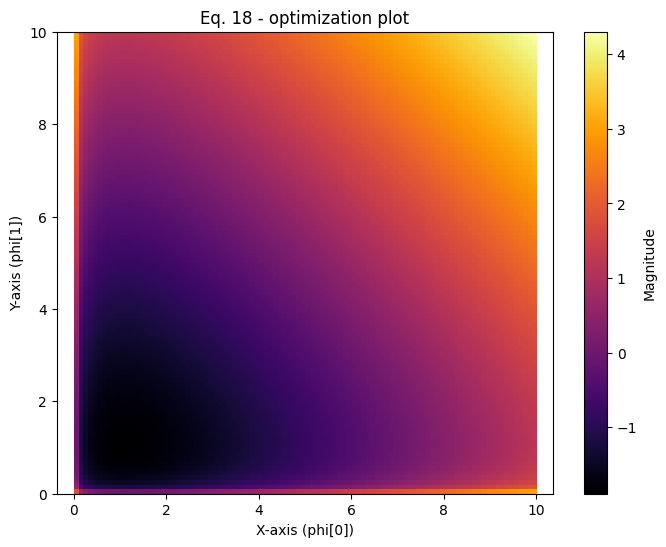

In [215]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = Parallel(n_jobs=-1)(
    delayed(D_KL)(
        np.array([20.5, 20.5, i, j]),
        data_fourier,
        target_model_1.get_trajectory()[0][frame-1],
        target_model_1.get_trajectory()[0][frame-1]
    )
    for i in D_KL_search_space
    for j in D_KL_search_space
)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(0), np.int64(0))


np.float64(-1.7666211487852395)

In [381]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [4.941e-01],  [4.686e-01]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [382]:
S_signals = Parallel(n_jobs=-1)(delayed(D_KL)(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1]) for n in tqdm(range(len(phis))))

100%|██████████| 10000/10000 [00:03<00:00, 3086.62it/s]


(100, 50)


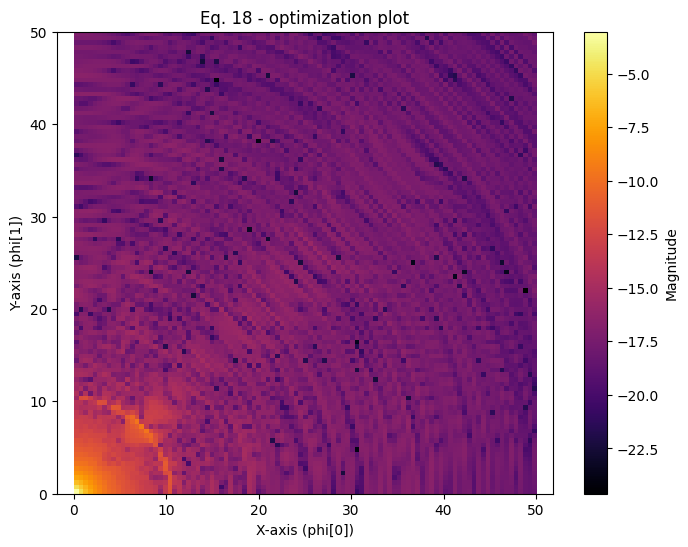

In [383]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)
print(heatmap[:100,:50].shape)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[1:,1:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno', aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [385]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(15), np.int64(15))
x: 7.575857575757576, y: 7.575857575757576


np.float64(-7.624926958932341e-05)

In [ ]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

In [ ]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

    #S_signals = Parallel(n_jobs=-1)(delayed(D_KL)(phis[n][:2].flatten(), data_fourier) for n in range(len(phis)))

    # Find the index of the minimum value in S_signals
    #min_index = np.argmin(S_signals)

    # Convert the flat index to 2D index
    #min_index_2d = np.unravel_index(min_index, (gridsize, gridsize))

    # Get the corresponding x and y values
    #epsbar_x = x_values[min_index_2d[1]]
    #epsbar_y = y_values[min_index_2d[0]]

    result = minimize(D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_), method="L-BFGS-B")

    #result = differential_evolution(D_KL, bounds, args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_))

    #result1 = differential_evolution(D_KL3_entropy, bounds1, args=(phi_bar_last_x_, phi_bar_last_y_, result.x[0], result.x[1]))

    return np.array([[result.x[0]], [result.x[1]], [result.x[2]], [result.x[3]]])


def message_passing(N_iter = 100, N = 10):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[5], [5], [0], [0]])]
    phi_eq18 = [np.array([[5], [5], [0], [0]])]
    phi_barbar_list = [np.array([[0.1,0,0,0], [0,0.1,0,0], [0,0,0,0], [0,0,0,0]])]

    Lambda_a = np.diagflat([0.1,0.1,0.1,0.1])


    for n in tqdm(range(N)):
        D_KL = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0], phi_barbar_list[n][0, 0], phi_barbar_list[n][1, 1])
        eps_bar = D_KL[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.000], [0.000]])))
        eps_bar_list.append(eps_bar)
        phi_eq18.append(eps_bar_list[n])
        eps_barbar_list.append(np.array([[D_KL[2][0],0,0,0], [0,D_KL[3][0],0,0], [0,0,1e20,0], [0,0,0,1e20]]))

        beta = np.zeros((4,4))
        alpha = n+1

        for _ in range(N_iter):
            for i in range(len(phi_bar_list)):
                if i-n == 0:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) * np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@np.linalg.inv(T)@phi_bar_list[i+1]
                    
                if n > 0:
                    beta += np.linalg.norm(np.linalg.inv(G)@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(np.linalg.inv(phi_bar_bar_inv)+T@phi_barbar_list[i]@T.T)@G_inv.T
        
        if n > 0:
            Lambda_a = np.linalg.inv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(np.linalg.inv(phi_bar_bar_inv))

        
    
    return phi_bar_list, phi_barbar_list, phi_eq18

In [ ]:
mrblat_data, mrblat_data_phibarbar, eq18 = message_passing()

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


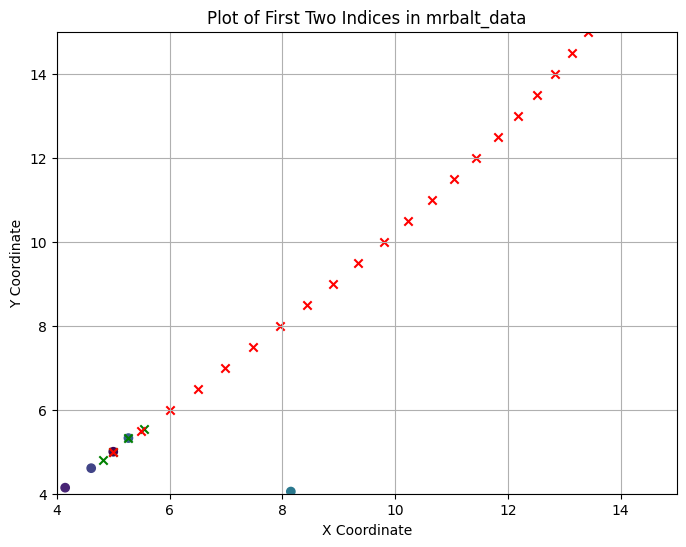

In [ ]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

x_coords1 = [data[0, 0] for data in eq18]
y_coords1 = [data[1, 0] for data in eq18]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.scatter(x_coords1, y_coords1, c='green', marker='x')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x')
plt.xlim([4, 15])
plt.ylim([4, 15])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of First Two Indices in mrbalt_data')
plt.grid(True)
plt.show()

In [ ]:
mrblat_data, mrblat_data_phibarbar

([array([[5],
         [5],
         [0],
         [0]]),
  array([[4.14663072],
         [4.14392407],
         [0.        ],
         [0.        ]]),
  array([[4.60845895],
         [4.60827267],
         [0.        ],
         [0.        ]]),
  array([[ 5.26915910e+00],
         [ 5.32494474e+00],
         [-2.37282196e-08],
         [-2.37782210e-08]]),
  array([[8.15058854e+00],
         [4.05178043e+00],
         [6.82120147e-13],
         [6.64176030e-13]]),
  array([[2.76358728e-01],
         [4.63570382e+00],
         [9.10881892e-18],
         [6.69372089e-18]]),
  array([[ 6.14299942e-04],
         [-3.23535679e-04],
         [-1.30925291e-18],
         [ 3.00644988e-19]]),
  array([[ 8.05961347e-07],
         [ 1.25601699e-06],
         [-4.07845643e-24],
         [ 4.05195943e-24]]),
  array([[-1.71048015e-07],
         [ 2.69502840e-07],
         [ 1.12969847e-30],
         [-1.62239832e-30]]),
  array([[-1.71048015e-07],
         [ 2.69502840e-07],
         [ 3.65599196e

In [ ]:
results = np.zeros((71, 4))

results[0] = np.array(([5, 5, 0.5, 0.5]))  # Initialize results as a list of lists

bounds = [(5,50), (5,50), (0.01, 10), (0.01, 10)]

for n in tqdm(range(70)):
    print(n)

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    #bounds = [(results[n-1, 0]-10,results[n-1, 0]+10), (results[n-1, 0]-10,results[n-1, 0]+10)]
    #print(bounds)
    result = minimize(D_KL, (results[n][0], results[n][1], 0.5, 0.5), args=(data_fourier, results[n][0], results[n][1]), method="L-BFGS-B")
    #result = differential_evolution(D_KL, [(5,50), (5,50), (0.01, 10), (0.01, 10)], args=(data_fourier, results[n][0], results[n][1]))

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([4, 20])
plt.ylim([4, 50])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'results' is not defined